# Venue Clustering in Singapore
#### Applied Data Science Capstone Project

## Introduction

### A friend of mine is wanting to travel to Singapore to kick-start her travel blog page. She wants to go to as many venues as possible to compare, contrast, and review them on her blog. To do this, she will have to know which areas of Singapore will be best to review such venues.

### She has explained that she wants to visit, review, and blog about 5 specific venue types:

#### 1. Coffee Shops
#### 2. Scenic Lookouts 
#### 3. Japanese Restaurants 
#### 4. Parks 
#### 5. Bubble Tea Shops 

### This notebook will retrieve, explore, cluster, and map different venues in Singapore according to the above specified categories.

### Importing all necessary libraries.

In [1]:
#!conda install -c conda-forge  basemap matplotlib==3.1 -y

#!pip install bs4
#!pip install html5lib
#!pip install lxml
#!pip install BeautifulSoup4
#!pip install geopy
#!pip install folium == upgrade
#!pip install geopy

import os
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors

from bs4 import BeautifulSoup
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas data frame library
from pandas.io.json import json_normalize

import folium # plotting library

import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
%matplotlib inline

print('Folium installed')
print('Libraries imported.')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Folium installed
Libraries imported.


## 1. Downloading and Exploring the Dataset

### First we need to scrape the web to get a list of different neighbourhoods in Singapore.

In [2]:
# Importing data from Wikipedia
df_regions = pd.read_html("http://en.wikipedia.org/wiki/Planning_Areas_of_Singapore", flavor='html5lib', header=0)[2]
df_regions.head()

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


### Then we will clean it up by getting rid of those columns that we dont need and re-naming the headers.

In [3]:
df_regions.rename(columns={'Name (English)':'Neighbourhood'}, inplace=True)
df_regions = df_regions[['Neighbourhood', 'Region', 'Area (km2)']]

#Reset the index 
df_regions.reset_index(drop=True)

df_regions.head()

,Neighbourhood,Region,Area (km2)
0,Ang Mo Kio,North-East,13.94
1,Bedok,East,21.69
2,Bishan,Central,7.62
3,Boon Lay,West,8.23
4,Bukit Batok,West,11.13


In [4]:
# Initialising geocoding agent
geolocator = Nominatim(user_agent="Mozilla/76.0")
location = geolocator.geocode("Singapore")
latitude = location.latitude
longitude = location.longitude
print(f"Coordinates of Singapore are {latitude}, {longitude}")

Coordinates of Singapore are 1.357107, 103.8194992


In [5]:
# Getting coordinates of each Planning Area, and adding suffix to search query
from tqdm import tqdm
from geopy.extra.rate_limiter import RateLimiter

tqdm.pandas()
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
coords = (df_regions['Neighbourhood'] + ' suburb, Singapore').progress_apply(geocode)

/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


### Next we will add the coordinates of each neighbourhood to the data frame as we will use this to find venues within a 2.5km radius later.

In [6]:
#adding new columns in df to be populated
df_regions["Latitude"] = np.nan
df_regions["Longitude"] = np.nan
df_regions.head()

,Neighbourhood,Region,Area (km2),Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,NaN,NaN
1,Bedok,East,21.69,NaN,NaN
2,Bishan,Central,7.62,NaN,NaN
3,Boon Lay,West,8.23,NaN,NaN
4,Bukit Batok,West,11.13,NaN,NaN


In [7]:
# Populating the Latitude and Longitude columns with data from coords
for index in df_regions.index:
    df_regions.at[index, 'Latitude'] = coords[index].latitude
    df_regions.at[index, 'Longitude'] = coords[index].longitude
    
df_regions.head()

,Neighbourhood,Region,Area (km2),Latitude,Longitude
0,Ang Mo Kio,North-East,13.94,1.369842,103.846609
1,Bedok,East,21.69,1.325670,103.931471
2,Bishan,Central,7.62,1.351912,103.848971
3,Boon Lay,West,8.23,1.313620,103.698827
4,Bukit Batok,West,11.13,1.348283,103.749019


### To get an idea of what this looks like and if it has been done correctly, let's map all neighbourhoods in Singapore that we have just retrieved.

In [8]:
# Visualising map using folium
# for loop used to add map markers for each Planning Area
map_singapore = folium.Map(location = [latitude, longitude], tiles='CartoDB positron', zoom_start = 11)
for lat, lng, region, name in zip(df_regions['Latitude'], df_regions['Longitude'], df_regions['Region'], df_regions['Neighbourhood']):
    label = '{}, {}'.format(name, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)

map_singapore

## 2. Exploring Neighbourhoods in Singapore

### So far so good, now let's use Foursquare to browse the information of the 100 most popular and recommended venues within a 2.5km radius of each neighbourhood. If there are not 100 venues within a neighbourhood, the search will gather all that are present. We will also get the address for each venue.

In [9]:
CLIENT_ID = 'EPB0CMFCP4RNU5N5LMUK4OHYELCW0LSWIZ3UGQPHQZUUJKWO' # your Foursquare ID
CLIENT_SECRET = '3XZK52PQN3RQZVZX504WGBKQ1LPJXVSSBPKR50JTMTANDKJQ' # your Foursquare Secret
ACCESS_TOKEN = 'VCJHKPGKJ3YGAI2OFOZROYEYBJOZC5SIR35IHY31QWN5R1AV' # your FourSquare Access Token
VERSION = '20201010'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EPB0CMFCP4RNU5N5LMUK4OHYELCW0LSWIZ3UGQPHQZUUJKWO
CLIENT_SECRET:3XZK52PQN3RQZVZX504WGBKQ1LPJXVSSBPKR50JTMTANDKJQ


In [10]:
def getNearbyVenues(names, latitudes, longitudes):
    radius= 2500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat, 
            lng,
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue ID',
                  'Venue Address',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
full_sg_venues = getNearbyVenues(names=df_regions['Neighbourhood'],
                                   latitudes=df_regions['Latitude'],
                                   longitudes=df_regions['Longitude'],
                                  )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [12]:
print(full_sg_venues.shape)
full_sg_venues.head()

(4185, 9)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue ID,Venue Address,Venue Latitude,Venue Longitude,Venue Category
0,Ang Mo Kio,1.369842,103.846609,Bishan - Ang Mo Kio Park,4b9f4875f964a520e21a37e3,"{'address': 'Ang Mo Kio Ave 1', 'lat': 1.36221...",1.362219,103.846250,Park
1,Ang Mo Kio,1.369842,103.846609,Old Chang Kee,4bc30123abf495215220c393,"{'address': 'AMK Hub', 'crossStreet': '53 Ang ...",1.369094,103.848389,Snack Place
2,Ang Mo Kio,1.369842,103.846609,Aramsa ~ The Garden Spa,4bea149f61aca5930d6d8300,"{'address': '1382 Ang Mo Kio Ave 1', 'crossStr...",1.362292,103.847602,Spa
3,Ang Mo Kio,1.369842,103.846609,FairPrice Xtra,4b15f661f964a52012b623e3,"{'address': '#B2-26 AMK Hub', 'crossStreet': '...",1.369279,103.848886,Supermarket
4,Ang Mo Kio,1.369842,103.846609,NTUC FairPrice,4ece4dd693ad987b4a9fb4ef,{'address': 'Blk 712 Ang Mo Kio Ave 6 #01-4056...,1.371507,103.847082,Supermarket


### The below diagram illustrates why we have to remove all duplicate values from the data frame.

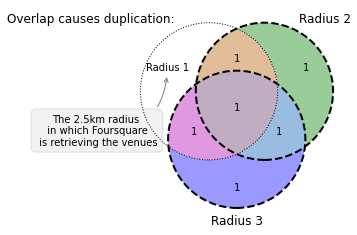

In [13]:
# libraries
#!pip install matplotlib
#!pip install matplotlib-venn

import pylab as plt
import matplotlib_venn as venn
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
 
# Make a Basic Venn
v = venn3(subsets=(1, 1, 1, 1, 1, 1, 1), set_labels = ('Radius 1', 'Radius 2', 'Radius 3'))
 
# To custom it
v.get_patch_by_id('100').set_alpha(1.0)
v.get_patch_by_id('100').set_color('white')
v.get_label_by_id('100').set_text('Radius 1')
v.get_label_by_id('A').set_text('Overlap causes duplication:')
c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_ls('dotted')
 
# Add title and annotation
# plt.title("Venn diagram title")
plt.annotate('The 2.5km radius \n in which Foursquare \n is retrieving the venues', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
 
# Show it
plt.show()


### Removing the duplicates from the data frame.

In [14]:
sg_venues = full_sg_venues.drop_duplicates(subset='Venue ID')
print('Number of duplicated venues removed: {}'.format(full_sg_venues.shape[0]-sg_venues.shape[0]))
print(sg_venues.shape)

Number of duplicated venues removed: 1588
(2597, 9)


### Now that we have up to 100 of the most popular venues within a radius of 2.5km of each neighbourhood, let's have a look at how many venues are present in each of these neighbourhoods.

In [15]:
sg_venues_count = sg_venues.groupby('Neighbourhood').count()
sg_venues_count = sg_venues_count.sort_values('Venue')
sg_venues_count.head()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue ID,Venue Address,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,,
River Valley,1,1,1,1,1,1,1,1
Sengkang,2,2,2,2,2,2,2,2
North-Eastern Islands,4,4,4,4,4,4,4,4
Western Islands,4,4,4,4,4,4,4,4
Southern Islands,4,4,4,4,4,4,4,4


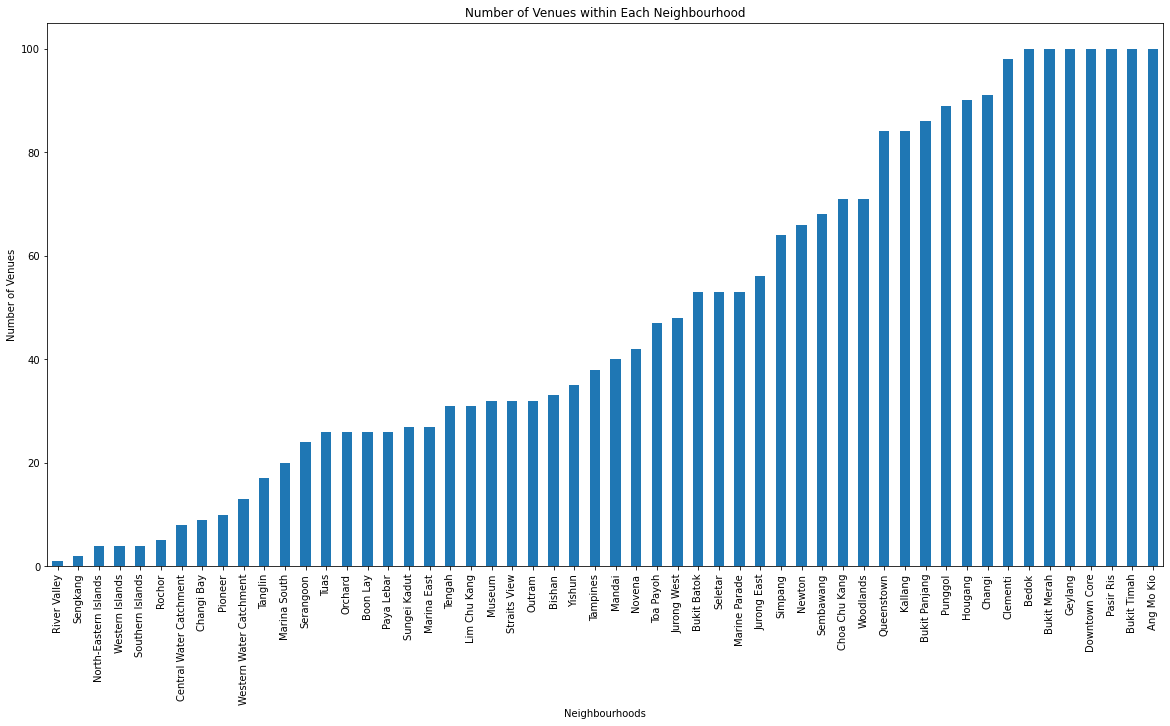

In [16]:
sg_venues_count['Venue'].plot(kind='bar', figsize=(20, 10))
plt.title('Number of Venues within Each Neighbourhood') # ad d a title to the histogram
plt.ylabel('Number of Venues') # add y-label
plt.xlabel('Neighbourhoods') # add x-label
plt.show()

## 3. Analysing Each Neighbourhood

In [17]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")
#sg_onehot.drop(['Neighbourhood'],axis=1,inplace=True) 
sg_onehot.insert(loc=0, column='Neighbourhood', value=sg_venues['Neighbourhood'] )
sg_onehot.shape

sg_grouped = sg_onehot.groupby('Neighbourhood').mean().reset_index()
sg_grouped.head()

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio,Yunnan Restaurant,Zoo,Zoo Exhibit
0,Ang Mo Kio,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.01,0.00,0.000000,0.0,0.000000,0.000000
1,Bedok,0.000000,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.01,0.010000,0.0,0.000000,0.000000
2,Bishan,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.000000
3,Boon Lay,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.038462,...,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.038462,0.076923
4,Bukit Batok,0.018868,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.00,0.00,0.018868,0.0,0.000000,0.000000


### Let's confirm the new size.

In [18]:
#sg_grouped size
sg_grouped.shape

(54, 306)

### Let's print each neighbourhood along with the top 5 most common venues.

In [19]:
num_top_venues = 5

for venue in sg_grouped['Neighbourhood']:
    print("----"+venue+"----")
    temp = sg_grouped[sg_grouped['Neighbourhood'] == venue].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ang Mo Kio----
                 venue  freq
0           Food Court  0.11
1   Chinese Restaurant  0.10
2          Coffee Shop  0.07
3                 Park  0.04
4  Japanese Restaurant  0.04


----Bedok----
                venue  freq
0  Chinese Restaurant  0.13
1          Food Court  0.07
2         Coffee Shop  0.07
3    Asian Restaurant  0.05
4  Seafood Restaurant  0.05


----Bishan----
            venue  freq
0     Flower Shop  0.09
1          Bakery  0.09
2      Food Court  0.06
3           Trail  0.06
4  Sandwich Place  0.06


----Boon Lay----
              venue  freq
0       Coffee Shop  0.15
1              Café  0.12
2           Exhibit  0.12
3       Zoo Exhibit  0.08
4  Asian Restaurant  0.04


----Bukit Batok----
                           venue  freq
0             Chinese Restaurant  0.13
1            Japanese Restaurant  0.08
2             Italian Restaurant  0.06
3  Vegetarian / Vegan Restaurant  0.04
4                  Shopping Mall  0.04


----Bukit Merah----
         

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Let's create a data frame and display the top 10 venues for each neighbourhood.

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data frame
sg_venues_sorted = pd.DataFrame(columns=columns)
sg_venues_sorted['Neighbourhood'] = sg_grouped['Neighbourhood']

for ind in np.arange(sg_grouped.shape[0]):
    sg_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

sg_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ang Mo Kio,Food Court,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Noodle House,Thai Restaurant,Park,Café,Bakery,Supermarket
1,Bedok,Chinese Restaurant,Food Court,Coffee Shop,Asian Restaurant,Seafood Restaurant,Café,Dessert Shop,Beach,Fast Food Restaurant,Bakery
2,Bishan,Flower Shop,Bakery,Trail,Food Court,Sandwich Place,Kids Store,Supermarket,Beer Garden,Thai Restaurant,South Indian Restaurant
3,Boon Lay,Coffee Shop,Café,Exhibit,Zoo Exhibit,Asian Restaurant,Office,Food Court,Cafeteria,Park,Shopping Mall
4,Bukit Batok,Chinese Restaurant,Japanese Restaurant,Italian Restaurant,Indian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Food Court,Shopping Mall,Hotpot Restaurant,Shoe Store
5,Bukit Merah,Café,Japanese Restaurant,Coffee Shop,Theme Park,Theme Park Ride / Attraction,Tapas Restaurant,Park,Dessert Shop,Sushi Restaurant,Chocolate Shop
6,Bukit Panjang,Supermarket,Coffee Shop,Fast Food Restaurant,Shopping Mall,Café,Food Court,Nature Preserve,Sushi Restaurant,Asian Restaurant,Trail
7,Bukit Timah,Chinese Restaurant,Japanese Restaurant,Bakery,Italian Restaurant,Café,Ice Cream Shop,Pizza Place,Food Court,Coffee Shop,Supermarket
8,Central Water Catchment,Park,Reservoir,Trail,Rest Area,Bridge,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Spot,Flower Shop
9,Changi,Airport Lounge,Coffee Shop,Airport Service,Chinese Restaurant,BBQ Joint,Fast Food Restaurant,Snack Place,Clothing Store,Bakery,Candy Store


### We now know the top 10 most common venues in each neighbourhood in Singapore, however, we are interested in 5 specific venue categories. Let's create the above again, but this time only for the venues of interest so that we can better understand where they are located in Singapore. We will filter to only get the below venues: 

#### 1. Coffee shops 
#### 2. Scenic lookouts 
#### 3. Japanese restaurants 
#### 4. Parks 
#### 5. Bubble tea shops 

In [22]:
venue_of_interest = sg_venues[['Neighbourhood','Venue', 'Venue Address', 'Venue Category','Venue ID', 'Venue Latitude', 'Venue Longitude']]

interest_df = venue_of_interest.loc[(venue_of_interest['Venue Category'] == 'Coffee Shop') | (venue_of_interest['Venue Category'] == 'Japanese Restaurant') | (venue_of_interest['Venue Category'] == 'Bubble Tea Shop') |(venue_of_interest['Venue Category'] == 'Park') | (venue_of_interest['Venue Category'] == 'Scenic Lookout')]
interest_df

,Neighbourhood,Venue,Venue Address,Venue Category,Venue ID,Venue Latitude,Venue Longitude
0,Ang Mo Kio,Bishan - Ang Mo Kio Park,"{'address': 'Ang Mo Kio Ave 1', 'lat': 1.36221...",Park,4b9f4875f964a520e21a37e3,1.362219,103.846250
8,Ang Mo Kio,Pond Gardens,"{'address': 'Bishan - Ang Mo Kio Park', 'cross...",Park,4ed8a3a4775bcc53f85b7400,1.366381,103.834190
14,Ang Mo Kio,ST31 Coffee Shop,"{'address': '347 Ang Mo Kio Avenue 3', 'lat': ...",Coffee Shop,4e61bc951f6ef7d07a688717,1.367478,103.848334
17,Ang Mo Kio,Prodigal Roasters,"{'address': 'Blk 625, Ang Mo Kio Ave 9', 'lat'...",Coffee Shop,57ced66f498eb312cf9a5f15,1.382212,103.841347
20,Ang Mo Kio,Ang Mo Kio Town Garden West,"{'address': 'Ang Mo Kio Ave 6', 'crossStreet':...",Park,4b95738df964a52046a334e3,1.376039,103.844528
...,...,...,...,...,...,...,...
4129,Yishun,Lower Seletar Reservoir Park,"{'address': 'Yishun Ave 1 & Lentor Avenue.', '...",Park,4b05880ff964a52028af22e3,1.410195,103.832345
4131,Yishun,848 Yishun St 81 24hr Coffeeshop,"{'address': '848 Yishun St 81', 'lat': 1.41619...",Coffee Shop,4bc883c22f94d13af2b4137f,1.416192,103.835038
4135,Yishun,Himawari @ OCC,"{'address': 'Orchid Country Club', 'crossStree...",Japanese Restaurant,520cc30711d20788be5fe8bc,1.413629,103.844720
4158,Yishun,Blk 632 Yishun Street 61,"{'address': 'Blk 632 Yishun St 61', 'lat': 1.4...",Coffee Shop,4c2eb6957cc0c9b632a4ea9a,1.418728,103.839408


In [23]:
interest_df.groupby('Neighbourhood').count().head()

,Venue,Venue Address,Venue Category,Venue ID,Venue Latitude,Venue Longitude
Neighbourhood,,,,,,
Ang Mo Kio,15,15,15,15,15,15
Bedok,12,12,12,12,12,12
Bishan,3,3,3,3,3,3
Boon Lay,6,6,6,6,6,6
Bukit Batok,8,8,8,8,8,8


In [24]:
print('There are {} unique Venue categories.'.format(len(interest_df['Venue Category'].unique())))

There are 5 unique Venue categories.


In [25]:
# one hot encoding
sg_onehot_interest = pd.get_dummies(interest_df[['Venue Category']], prefix="", prefix_sep="")
#sg_onehot_interest.drop(['Neighbourhood'],axis=1,inplace=True) 
sg_onehot_interest.insert(loc=0, column='Neighbourhood', value=interest_df['Neighbourhood'] )
sg_onehot_interest.shape

sg_grouped_interest = sg_onehot_interest.groupby('Neighbourhood').mean().reset_index()
sg_grouped_interest.head()

,Neighbourhood,Bubble Tea Shop,Coffee Shop,Japanese Restaurant,Park,Scenic Lookout
0,Ang Mo Kio,0.000000,0.466667,0.266667,0.266667,0.000000
1,Bedok,0.083333,0.583333,0.166667,0.166667,0.000000
2,Bishan,0.000000,0.333333,0.333333,0.333333,0.000000
3,Boon Lay,0.000000,0.666667,0.000000,0.166667,0.166667
4,Bukit Batok,0.125000,0.250000,0.500000,0.125000,0.000000


In [26]:
num_top_venues_interest = 5

for venue in sg_grouped_interest['Neighbourhood']:
    print("----"+venue+"----")
    temp = sg_grouped_interest[sg_grouped_interest['Neighbourhood'] == venue].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues_interest))
    print('\n')

----Ang Mo Kio----
                 venue  freq
0          Coffee Shop  0.47
1  Japanese Restaurant  0.27
2                 Park  0.27
3      Bubble Tea Shop  0.00
4       Scenic Lookout  0.00


----Bedok----
                 venue  freq
0          Coffee Shop  0.58
1  Japanese Restaurant  0.17
2                 Park  0.17
3      Bubble Tea Shop  0.08
4       Scenic Lookout  0.00


----Bishan----
                 venue  freq
0          Coffee Shop  0.33
1  Japanese Restaurant  0.33
2                 Park  0.33
3      Bubble Tea Shop  0.00
4       Scenic Lookout  0.00


----Boon Lay----
                 venue  freq
0          Coffee Shop  0.67
1                 Park  0.17
2       Scenic Lookout  0.17
3      Bubble Tea Shop  0.00
4  Japanese Restaurant  0.00


----Bukit Batok----
                 venue  freq
0  Japanese Restaurant  0.50
1          Coffee Shop  0.25
2      Bubble Tea Shop  0.12
3                 Park  0.12
4       Scenic Lookout  0.00


----Bukit Merah----
               

In [27]:
def return_most_common_venues1(row, num_top_venues_interest):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues_interest]

In [28]:
num_top_venues1 = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues_interest):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new data frame
sg_voi_sorted = pd.DataFrame(columns=columns)
sg_voi_sorted['Neighbourhood'] = sg_grouped_interest['Neighbourhood']

for ind in np.arange(sg_grouped_interest.shape[0]):
    sg_voi_sorted.iloc[ind, 1:] = return_most_common_venues1(sg_grouped_interest.iloc[ind, :], num_top_venues_interest)

sg_voi_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,Coffee Shop,Park,Japanese Restaurant,Scenic Lookout,Bubble Tea Shop
1,Bedok,Coffee Shop,Park,Japanese Restaurant,Bubble Tea Shop,Scenic Lookout
2,Bishan,Park,Japanese Restaurant,Coffee Shop,Scenic Lookout,Bubble Tea Shop
3,Boon Lay,Coffee Shop,Scenic Lookout,Park,Japanese Restaurant,Bubble Tea Shop
4,Bukit Batok,Japanese Restaurant,Coffee Shop,Park,Bubble Tea Shop,Scenic Lookout
5,Bukit Merah,Japanese Restaurant,Coffee Shop,Park,Scenic Lookout,Bubble Tea Shop
6,Bukit Panjang,Coffee Shop,Park,Bubble Tea Shop,Scenic Lookout,Japanese Restaurant
7,Bukit Timah,Japanese Restaurant,Coffee Shop,Scenic Lookout,Park,Bubble Tea Shop
8,Central Water Catchment,Park,Scenic Lookout,Japanese Restaurant,Coffee Shop,Bubble Tea Shop
9,Changi,Coffee Shop,Japanese Restaurant,Park,Bubble Tea Shop,Scenic Lookout


## 4. K-Means Clustering

### Finding the number for K - Elbow Method 

In [29]:
distortions = []

k_sg_grouped_interest =  sg_grouped_interest.drop('Neighbourhood', 1)

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(k_sg_grouped_interest)
    distortions.append(kmean.inertia_)

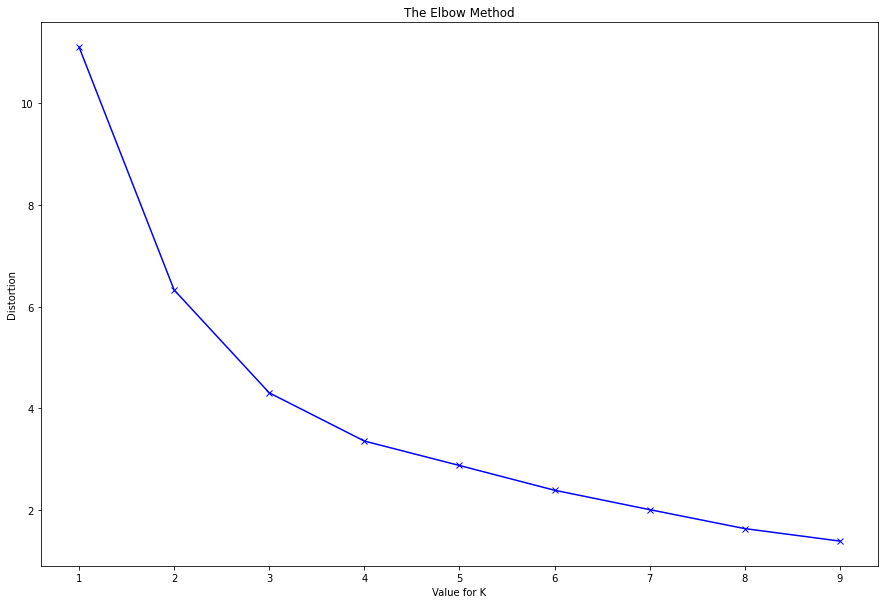

In [30]:
plt.figure(figsize=(15,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Value for K')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

### Performing the clustering with the optimal value of k=3.

In [31]:
# set number of clusters
kclusters = 3

sg_grouped_clustering = sg_grouped_interest.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the data frame
kmeans.labels_[0:10] 

array([2, 1, 2, 1, 0, 0, 1, 0, 2, 1], dtype=int32)

In [32]:
# add clustering labels
sg_voi_sorted.insert(0, 'K-Means Cluster', kmeans.labels_)

sg_merged = df_regions

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighbourhood
sg_merged = sg_merged.join(sg_voi_sorted.set_index('Neighbourhood'), on='Neighbourhood')

sg_merged = sg_merged.dropna() # check the last columns!

In [33]:
#sg_merged['Cluster Labels'] = pd.to_numeric(sg_merged['Cluster Labels'])
#sg_merged.dropna()
sg_merged['K-Means Cluster'] = sg_merged['K-Means Cluster'].astype(int)

### To visualize the clusters in Singapore, let's map them below.

### Legend: 
#### Red - Japanese Restaurants
#### Purple - Coffee Shops
#### Green - Predominantly Parks 

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles='CartoDB positron', zoom_start = 12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['Neighbourhood'], sg_merged['K-Means Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. DBSCAN Clustering

In [35]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = sg_grouped_interest.drop('Neighbourhood', 1)
Clus_dataSet = Clus_dataSet.dropna()
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=2).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
sg_grouped_interest['DBSCAN Cluster']=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

sg_voi_sorted.insert(0, 'DBSCAN Cluster', kmeans.labels_)


db_clustering_df = df_regions
db_clustering_df = db_clustering_df.join(sg_voi_sorted.set_index('Neighbourhood'), on='Neighbourhood')

# A sample of clusters
db_clustering_df= db_clustering_df.dropna()
db_clustering_df['DBSCAN Cluster'] = db_clustering_df['DBSCAN Cluster'].astype(int)
db_clustering_df.head()

,Neighbourhood,Region,Area (km2),Latitude,Longitude,DBSCAN Cluster,K-Means Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Ang Mo Kio,North-East,13.94,1.369842,103.846609,2,2.0,Coffee Shop,Park,Japanese Restaurant,Scenic Lookout,Bubble Tea Shop
1,Bedok,East,21.69,1.325670,103.931471,1,1.0,Coffee Shop,Park,Japanese Restaurant,Bubble Tea Shop,Scenic Lookout
2,Bishan,Central,7.62,1.351912,103.848971,2,2.0,Park,Japanese Restaurant,Coffee Shop,Scenic Lookout,Bubble Tea Shop
3,Boon Lay,West,8.23,1.313620,103.698827,1,1.0,Coffee Shop,Scenic Lookout,Park,Japanese Restaurant,Bubble Tea Shop
4,Bukit Batok,West,11.13,1.348283,103.749019,0,0.0,Japanese Restaurant,Coffee Shop,Park,Bubble Tea Shop,Scenic Lookout


## 5.1 Examining Each DBSCAN and K-Means Cluster

### Cluster 0 - Japanese Restaurants

In [36]:
Clus1 = db_clustering_df.loc[(db_clustering_df['DBSCAN Cluster'] == 0)]
Clus1[['DBSCAN Cluster', 'K-Means Cluster', '1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,DBSCAN Cluster,K-Means Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,0,0.0,Japanese Restaurant,Coffee Shop,Park
5,0,0.0,Japanese Restaurant,Coffee Shop,Park
7,0,0.0,Japanese Restaurant,Coffee Shop,Scenic Lookout
13,0,0.0,Japanese Restaurant,Scenic Lookout,Park
21,0,0.0,Japanese Restaurant,Scenic Lookout,Park
23,0,0.0,Japanese Restaurant,Coffee Shop,Park
25,0,0.0,Japanese Restaurant,Coffee Shop,Scenic Lookout
27,0,0.0,Japanese Restaurant,Coffee Shop,Scenic Lookout
28,0,0.0,Japanese Restaurant,Coffee Shop,Bubble Tea Shop
29,0,0.0,Japanese Restaurant,Scenic Lookout,Park


### Cluster 1 -  Coffee Shops

In [37]:
Clus2 = db_clustering_df.loc[(db_clustering_df['DBSCAN Cluster'] == 1)]
Clus2[['DBSCAN Cluster', 'K-Means Cluster', '1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,DBSCAN Cluster,K-Means Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,1,1.0,Coffee Shop,Park,Japanese Restaurant
3,1,1.0,Coffee Shop,Scenic Lookout,Park
6,1,1.0,Coffee Shop,Park,Bubble Tea Shop
9,1,1.0,Coffee Shop,Japanese Restaurant,Park
14,1,1.0,Coffee Shop,Bubble Tea Shop,Scenic Lookout
15,1,1.0,Coffee Shop,Park,Japanese Restaurant
16,1,1.0,Coffee Shop,Scenic Lookout,Park
18,1,1.0,Coffee Shop,Japanese Restaurant,Park
31,1,1.0,Coffee Shop,Park,Scenic Lookout
32,1,1.0,Coffee Shop,Scenic Lookout,Park


### Cluster 2 - Predominantly Parks 

In [38]:
Clus3 = db_clustering_df.loc[(db_clustering_df['DBSCAN Cluster'] == 2)]
Clus3[['DBSCAN Cluster', 'K-Means Cluster', '1st Most Common Venue','2nd Most Common Venue', '3rd Most Common Venue']]

,DBSCAN Cluster,K-Means Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,2,2.0,Coffee Shop,Park,Japanese Restaurant
2,2,2.0,Park,Japanese Restaurant,Coffee Shop
8,2,2.0,Park,Scenic Lookout,Japanese Restaurant
11,2,2.0,Coffee Shop,Park,Japanese Restaurant
12,2,2.0,Park,Japanese Restaurant,Coffee Shop
17,2,2.0,Park,Coffee Shop,Scenic Lookout
19,2,2.0,Scenic Lookout,Park,Japanese Restaurant
20,2,2.0,Park,Coffee Shop,Scenic Lookout
24,2,2.0,Park,Japanese Restaurant,Coffee Shop
30,2,2.0,Park,Coffee Shop,Japanese Restaurant


## 6. Creating an Interactive Cluster Map of the Venues of Interest

### You will be able to click on each venue to get its name as well as zoom in and out.

In [39]:
from folium.plugins import MarkerCluster

# Visualising map using folium
# for loop used to add map markers for each Planning Area
map3_singapore = folium.Map(location = [latitude, longitude], tiles='CartoDB positron', zoom_start = 12)

marker_cluster = MarkerCluster().add_to(map3_singapore)


for lat, lng, region, name in zip(interest_df['Venue Latitude'], interest_df['Venue Longitude'], interest_df['Venue Category'], interest_df['Neighbourhood']):
    label = '{}, {}'.format(region, name)
    label = folium.Popup(label, parse_html=True)
    icon = folium.features.CustomIcon('https://cdn0.iconfinder.com/data/icons/small-n-flat/24/678111-map-marker-512.png', icon_size = (50,50))
    folium.Marker(
        [lat, lng],
        popup = label, 
        icon = icon).add_to(marker_cluster)

map3_singapore

## 7. Simplified Map for Venues not Included in the Clustering  

### As Bubble tea shops and scenic lookouts were not included in the clustering due to scarcety compared to restaurants and coffee shops, the below map acts as a supplement to the clustering. Only the below categories are shown.

#### 1. Scenic lookouts 
#### 2. Bubble tea shops 

In [40]:
scenic_df = venue_of_interest.loc[(venue_of_interest['Venue Category'] == 'Bubble Tea Shop') | (venue_of_interest['Venue Category'] == 'Scenic Lookout')]

In [41]:
map4_singapore = folium.Map(location = [latitude, longitude], tiles='CartoDB positron', zoom_start = 12)

marker_cluster = MarkerCluster().add_to(map4_singapore)


for lat, lng, region, name in zip(scenic_df['Venue Latitude'], scenic_df['Venue Longitude'], scenic_df['Venue Category'], scenic_df['Neighbourhood']):
    label = '{}, {}'.format(region, name)
    label = folium.Popup(label, parse_html=True)
    icon = folium.features.CustomIcon('https://cdn0.iconfinder.com/data/icons/small-n-flat/24/678111-map-marker-512.png', icon_size = (50,50))
    folium.Marker(
        [lat, lng],
        popup = label, 
        icon = icon).add_to(marker_cluster)

map4_singapore